In [2]:
%pwd

'c:\\Users\\44787\\Desktop\\projects\\end-to-end-SMS-Spam-classifier\\research'

In [3]:
import os

os.chdir('../')
%pwd

'c:\\Users\\44787\\Desktop\\projects\\end-to-end-SMS-Spam-classifier'

## Import Libraries

In [4]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer


### Data loading, EDA and feature engineering

In [5]:
data_path = Path('artifacts/data_ingestion/SMS-Spam/spam.csv')
data_path

WindowsPath('artifacts/data_ingestion/SMS-Spam/spam.csv')

In [8]:
df = pd.read_csv(data_path, encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
## remove unnecessary columns
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [10]:
## rename columns name
df.rename(columns={'v1': 'target', 'v2': 'msg'}, inplace=True)
df.head()

,target,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5572 non-null   object
 1   msg     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


**check for null values**

In [12]:
df.isnull().sum()

target    0
msg       0
dtype: int64

In [13]:
# check if any msg bodies are null
df['msg'].isnull().values.any()

False

In [14]:
# check if there are empty msg
(df.msg.str.len() == 0).any()

False

**check for duplicate values**

In [15]:
df.duplicated().sum()

403

In [16]:
## remove duplicates
df.drop_duplicates(keep='first', inplace=True)

**check whether balacne or not**

In [17]:
df.target.value_counts(normalize=True)

target
ham     0.87367
spam    0.12633
Name: proportion, dtype: float64

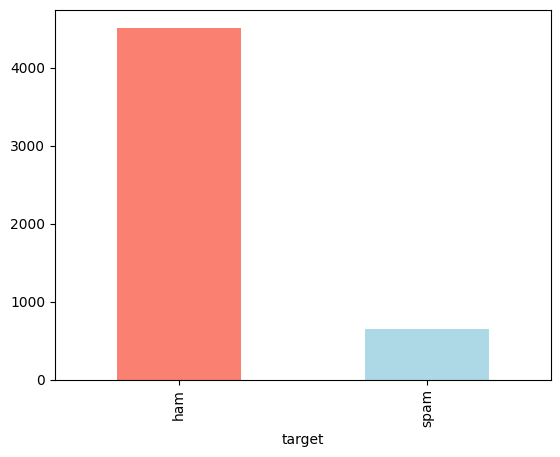

In [18]:
df.target.value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

**convert target to categorical values**

In [19]:
df.target = df.target.replace({'ham': 0, 'spam': 1})

C:\Users\44787\AppData\Local\Temp\ipykernel_20148\3214997855.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.target = df.target.replace({'ham': 0, 'spam': 1})


In [20]:
df.head()

,target,msg
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


#### creation of `num_characters`,`num_words`,`num_sentences` 

In [21]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\44787\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
df['num_characters'] = df['msg'].apply(len)
df.head()

,target,msg,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [23]:
df['num_words'] = df['msg'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

,target,msg,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [24]:
df['num_sentences'] = df['msg'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,target,msg,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [25]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [26]:
# ham
df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [27]:
# spam
df[df['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


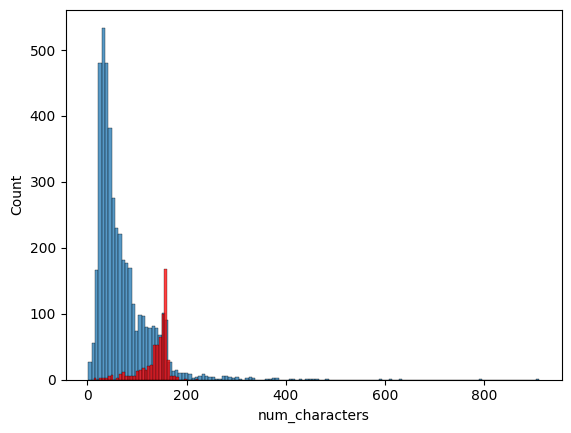

In [28]:
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'],color='red');

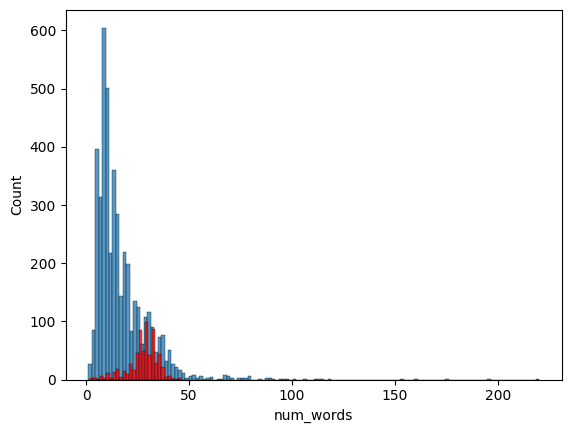

In [29]:
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'],color='red');

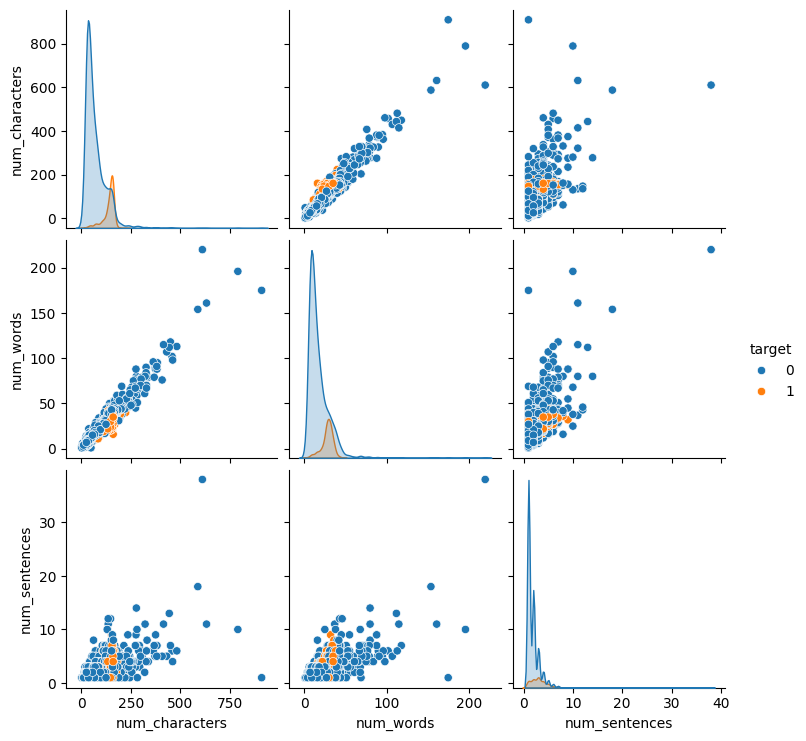

In [30]:
sns.pairplot(df,hue='target');

#### Text Pre-Processing
- Converting to lower case
- Tokenising
- Removing stop words
- Words stemming
- Removing punctuation
- Stripping out html tags

In [31]:
def clean_msg(msg, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    
    # remove html tags
    soup = BeautifulSoup(msg, 'html.parser')
    clean_text = soup.get_text()
    
    # convert to lower case and splits up the words
    words = word_tokenize(clean_text.lower())
    
    filter_words = []
    
    for word in words:
        # removing the stop words and punctuation 
        if word not in stop_words and word.isalpha():
            filter_words.append(stemmer.stem(word)) # words stemming
    
    return ' '.join(filter_words)

In [32]:
df.msg = df.msg.apply(clean_msg)
df.head()

C:\Users\44787\AppData\Local\Temp\ipykernel_20148\2222497336.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(msg, 'html.parser')


,target,msg,num_characters,num_words,num_sentences
0,0,go jurong point crazi avail bugi n great world...,111,24,2
1,0,ok lar joke wif u oni,29,8,2
2,1,free entri wkli comp win fa cup final tkt may ...,155,37,2
3,0,u dun say earli hor u c alreadi say,49,13,1
4,0,nah think goe usf live around though,61,15,1


#### using wordcloud and checking the most common words in spam and ham messages

In [33]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [34]:
spam_wc = wc.generate(df[df['target'] == 1]['msg'].str.cat(sep=" "))

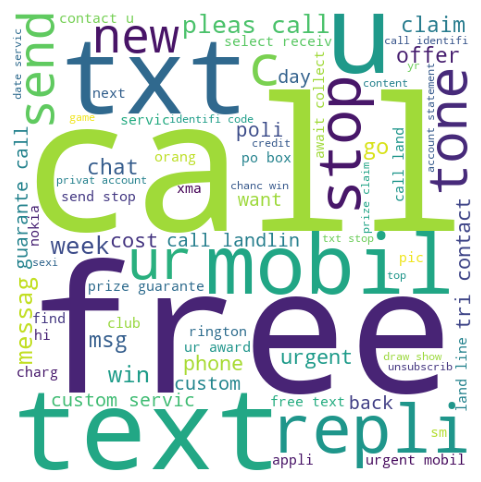

In [35]:
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)
plt.axis("off")
plt.show()

In [36]:
ham_wc = wc.generate(df[df['target'] == 0]['msg'].str.cat(sep=" "))

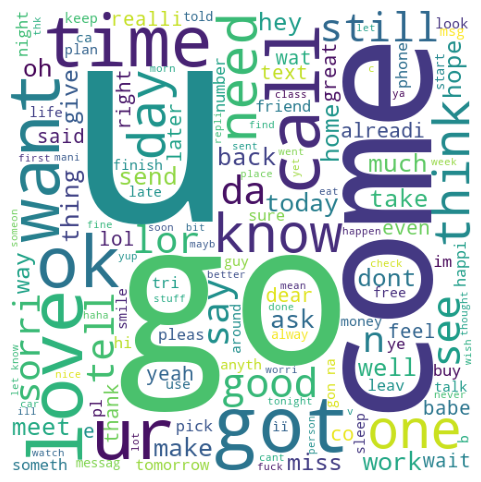

In [37]:
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)
plt.axis('off')
plt.show()

In [38]:
spam_corpus = []
for msg in df[df['target'] == 1]['msg'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [39]:
len(spam_corpus)

8164

In [40]:
pd.DataFrame(Counter(spam_corpus).most_common(20))

,0,1
0,call,320
1,free,191
2,txt,141
3,text,122
4,u,119
5,ur,119
6,mobil,114
7,stop,104
8,repli,103
9,claim,98


In [41]:
ham_corpus = []
for msg in df[df['target'] == 0]['msg'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [42]:
pd.DataFrame(Counter(ham_corpus).most_common(20))

,0,1
0,u,883
1,go,404
2,get,349
3,come,275
4,got,236
5,know,236
6,like,234
7,call,233
8,time,219
9,ok,217


#### tfidfvectorizer

In [43]:
df.head()

,target,msg,num_characters,num_words,num_sentences
0,0,go jurong point crazi avail bugi n great world...,111,24,2
1,0,ok lar joke wif u oni,29,8,2
2,1,free entri wkli comp win fa cup final tkt may ...,155,37,2
3,0,u dun say earli hor u c alreadi say,49,13,1
4,0,nah think goe usf live around though,61,15,1


In [44]:
tfv = TfidfVectorizer(max_features=2500)
X = tfv.fit_transform(df.msg).toarray()

In [45]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
y = df.target
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: target, Length: 5169, dtype: int64

#### blance the dataset

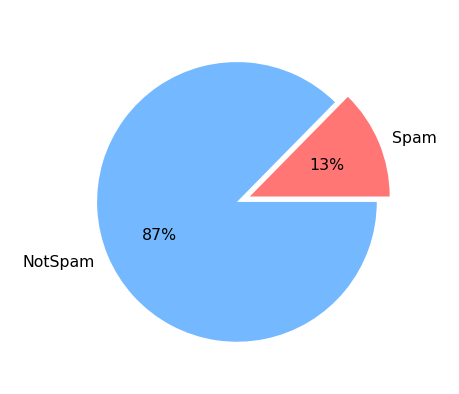

In [47]:
amount_ham = df.target.value_counts()[0]
amount_spam = df.target.value_counts()[1]

category_name = ['Spam', 'NotSpam']
sizes = [amount_spam ,amount_ham]
custom_color = ['#ff7675', '#74b9ff'] 


plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_name,textprops={'fontsize': 5},autopct='%1.0f%%',
                                colors = custom_color, explode = [0, 0.1])
plt.show()

In [49]:
from imblearn.over_sampling import RandomOverSampler

smote = RandomOverSampler(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

In [50]:
y_sm.value_counts()

target
0    4516
1    4516
Name: count, dtype: int64

#### split the dataset

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.20, random_state=42)

### Model

In [52]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [53]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[842,  42],
       [ 36, 887]], dtype=int64)

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       884
           1       0.95      0.96      0.96       923

    accuracy                           0.96      1807
   macro avg       0.96      0.96      0.96      1807
weighted avg       0.96      0.96      0.96      1807

